In [1]:
import numpy as np
import pandas as pd

In [2]:
#train 有35156筆資料，test 有34844筆資料。
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#'test.csv'的 Weather 欄位用 0 補起來。
df_test['Weather'] = np.zeros((len(df_test),))

df.drop('Date', axis=1, inplace=True)
df_test.drop('Date', axis=1, inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Loc'] = le.fit_transform(df['Loc'])
df['WindDir'] = le.fit_transform(df['WindDir'])
df['DayWindDir'] = le.fit_transform(df['DayWindDir'])
df['NightWindDir'] = le.fit_transform(df['NightWindDir'])

df_test['Loc'] = le.fit_transform(df_test['Loc'])
df_test['WindDir'] = le.fit_transform(df_test['WindDir'])
df_test['DayWindDir'] = le.fit_transform(df_test['DayWindDir'])
df_test['NightWindDir'] = le.fit_transform(df_test['NightWindDir'])

In [4]:
#fill nan with median
df.fillna(df.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

In [5]:
#make the training data balanced with SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop('Weather', axis=1), df['Weather'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

RF accuracy: 0.9241401223290174
RF f1 score: 0.9254895841460561


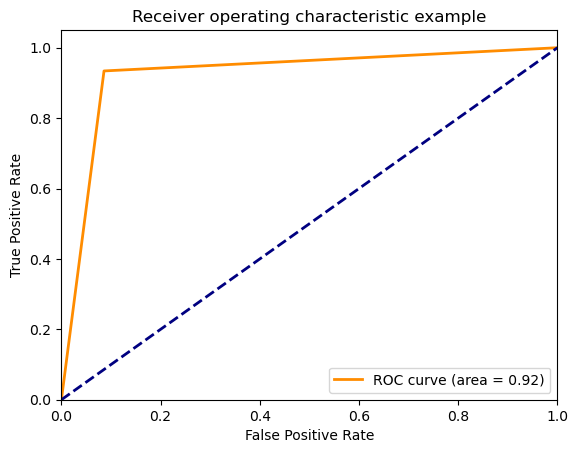

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

RF = RandomForestClassifier(n_estimators=100, criterion="gini")
RF.fit(X_train, y_train)
y_pred_rf = RF.predict(X_test)

print('RF accuracy:', accuracy_score(y_test, y_pred_rf))
print('RF f1 score:', f1_score(y_test, y_pred_rf))

#plt ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
#use lightgbm to predict
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 250,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = (y_pred_lgb > 0.5).astype(int)
# eval
print('The roc of prediction is:', roc_auc_score(y_test, y_pred_binary))
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred_binary))
print('The f1 score of prediction is:', f1_score(y_test, y_pred_binary))

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_logloss: 0.669561	valid_0's auc: 0.892296
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.649231	valid_0's auc: 0.899523
[3]	valid_0's binary_logloss: 0.629437	valid_0's auc: 0.903788
[4]	valid_0's binary_logloss: 0.613594	valid_0's auc: 0.90851
[5]	valid_0's binary_logloss: 0.597843	valid_0's auc: 0.91051
[6]	valid_0's binary_logloss: 0.583196	valid_0's auc: 0.914888
[7]	valid_0's binary_logloss: 0.566329	valid_0's auc: 0.91982
[8]	valid_0's binary_logloss: 0.55201	valid_0's auc: 0.921675
[9]	valid_0's binary_logloss: 0.539319	valid_0's auc: 0.923331
[10]	valid_0's binary_logloss: 0.527636	valid_0's auc: 0.924101


c:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	valid_0's binary_logloss: 0.517598	valid_0's auc: 0.924561
[12]	valid_0's binary_logloss: 0.508352	valid_0's auc: 0.925344
[13]	valid_0's binary_logloss: 0.4971	valid_0's auc: 0.927261
[14]	valid_0's binary_logloss: 0.488168	valid_0's auc: 0.928175
[15]	valid_0's binary_logloss: 0.479705	valid_0's auc: 0.929725
[16]	valid_0's binary_logloss: 0.471626	valid_0's auc: 0.930769
[17]	valid_0's binary_logloss: 0.464625	valid_0's auc: 0.931304
[18]	valid_0's binary_logloss: 0.456669	valid_0's auc: 0.932948
[19]	valid_0's binary_logloss: 0.450003	valid_0's auc: 0.933513
[20]	valid_0's binary_logloss: 0.443279	valid_0's auc: 0.934271
[21]	valid_0's binary_logloss: 0.437251	valid_0's auc: 0.934755
[22]	valid_0's binary_logloss: 0.431906	valid_0's auc: 0.935149
[23]	valid_0's binary_logloss: 0.423827	valid_0's auc: 0.937624
[24]	valid_0's binary_logloss: 0.417711	valid_0's auc: 0.938726
[25]	valid_0's binary_logloss: 0.412281	valid_0's auc: 0.939569
[26]	valid_0's binary_logloss: 0.405803	va

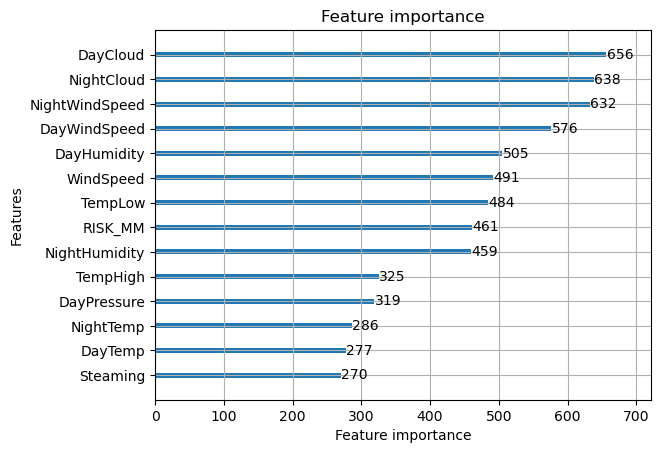

Loc : 218
TempLow : 484
TempHigh : 325
Steaming : 270
Sun : 198
WindDir : 169
WindSpeed : 491
DayWindDir : 197
NightWindDir : 169
DayWindSpeed : 576
NightWindSpeed : 632
DayHumidity : 505
NightHumidity : 459
DayPressure : 319
NightPressure : 170
DayCloud : 656
NightCloud : 638
DayTemp : 277
NightTemp : 286
RISK_MM : 461


In [9]:
# plot feature importance
lgb.plot_importance(gbm, max_num_features=14)
plt.show()

# print feature importance in table form
feature_importance = list(gbm.feature_importance())
feature_names = list(gbm.feature_name())
for i in range(len(feature_importance)):
    print(feature_names[i], ":", feature_importance[i])

feature_names = feature_names[:13]

In [10]:
# #Do PCA to reduce the dimension of the data
# from sklearn.decomposition import PCA

# pca = PCA(n_components=13)
# pca.fit(X_train)
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)

In [18]:
#only use the feature in feature_names to do light gbm
X_train = X_train[feature_names]
X_test = X_test[feature_names]

#use lightgbm to predict
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 250,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Start predicting...')
# predict

y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = (y_pred_lgb > 0.5).astype(int)
# eval
print('The roc of prediction is:', roc_auc_score(y_test, y_pred_binary))
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred_binary))
print('The f1 score of prediction is:', f1_score(y_test, y_pred_binary))

Start training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.677769	valid_0's auc: 0.820961
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.663322	valid_0's auc: 0.833983
[3]	valid_0's binary_logloss: 0.650055	valid_0's auc: 0.840579
[4]	valid_0's binary_logloss: 0.637998	valid_0's auc: 0.844849
[5]	valid_0's binary_logloss: 0.626902	valid_0's auc: 0.845644
[6]	valid_0's binary_logloss: 0.615293	valid_0's auc: 0.855507
[7]	valid_0's binary_logloss: 0.605333	valid_0's auc: 0.857533
[8]	valid_0's binary_logloss: 0.596322	valid_0's auc: 0.863706
[9]	valid_0's binary_logloss: 0.587267	valid_0's auc: 0.867173
[10]	valid_0's binary_logloss: 0.578684	valid_0's auc: 0.869914
[11]	valid_0's binary_logloss: 0.570862	valid_0's auc: 0.871503
[12]	valid_0's binary_logloss: 0.563076	valid_0's auc: 0.87474

c:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[16]	valid_0's binary_logloss: 0.536093	valid_0's auc: 0.88102
[17]	valid_0's binary_logloss: 0.52968	valid_0's auc: 0.883237
[18]	valid_0's binary_logloss: 0.523917	valid_0's auc: 0.8846
[19]	valid_0's binary_logloss: 0.516376	valid_0's auc: 0.889814
[20]	valid_0's binary_logloss: 0.510986	valid_0's auc: 0.89125
[21]	valid_0's binary_logloss: 0.50167	valid_0's auc: 0.898597
[22]	valid_0's binary_logloss: 0.496364	valid_0's auc: 0.899919
[23]	valid_0's binary_logloss: 0.488118	valid_0's auc: 0.905155
[24]	valid_0's binary_logloss: 0.483528	valid_0's auc: 0.905881
[25]	valid_0's binary_logloss: 0.4773	valid_0's auc: 0.908969
[26]	valid_0's binary_logloss: 0.472787	valid_0's auc: 0.90995
[27]	valid_0's binary_logloss: 0.468066	valid_0's auc: 0.911171
[28]	valid_0's binary_logloss: 0.464351	valid_0's auc: 0.911486
[29]	valid_0's binary_logloss: 0.460621	valid_0's auc: 0.912101
[30]	valid_0's binary_logloss: 0.456633	valid_0's auc: 0.913019
[31]	valid_0's binary_logloss: 0.452055	valid_0's

In [19]:
#use xgboost to do the same thing
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_test, label=y_test)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'lambda': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

watchlist = [(xgb_train, 'train'), (xgb_eval, 'val')]
num_round = 250
bst = xgb.train(params, xgb_train, num_round, watchlist, early_stopping_rounds=5)

y_pred_xgb = bst.predict(xgb_eval)

y_pred_binary = (y_pred_xgb > 0.4).astype(int)
# eval
print('The roc of prediction is:', roc_auc_score(y_test, y_pred_binary))
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred_binary))

[0]	train-auc:0.80775	val-auc:0.80245
[1]	train-auc:0.86154	val-auc:0.85420
[2]	train-auc:0.87079	val-auc:0.86440


c:\Users\user\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[3]	train-auc:0.87396	val-auc:0.86876
[4]	train-auc:0.87591	val-auc:0.87002
[5]	train-auc:0.88181	val-auc:0.87427
[6]	train-auc:0.88503	val-auc:0.87735
[7]	train-auc:0.88736	val-auc:0.88019
[8]	train-auc:0.88940	val-auc:0.88236
[9]	train-auc:0.89245	val-auc:0.88503
[10]	train-auc:0.89506	val-auc:0.88791
[11]	train-auc:0.90191	val-auc:0.89583
[12]	train-auc:0.90314	val-auc:0.89722
[13]	train-auc:0.90695	val-auc:0.90105
[14]	train-auc:0.91133	val-auc:0.90557
[15]	train-auc:0.91282	val-auc:0.90673
[16]	train-auc:0.91424	val-auc:0.90849
[17]	train-auc:0.91565	val-auc:0.90984
[18]	train-auc:0.91658	val-auc:0.91063
[19]	train-auc:0.91704	val-auc:0.91131
[20]	train-auc:0.91884	val-auc:0.91297
[21]	train-auc:0.92239	val-auc:0.91659
[22]	train-auc:0.92291	val-auc:0.91703
[23]	train-auc:0.92506	val-auc:0.91924
[24]	train-auc:0.92586	val-auc:0.92011
[25]	train-auc:0.92773	val-auc:0.92208
[26]	train-auc:0.92893	val-auc:0.92305
[27]	train-auc:0.92987	val-auc:0.92384
[28]	train-auc:0.93178	val-auc:0

In [13]:
#use catboost to do the same thing
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(iterations=250, learning_rate=0.05, depth=6, loss_function='Logloss', eval_metric='AUC', random_seed=42, od_type='Iter', metric_period=50, od_wait=20)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=True)

y_pred_cat = model.predict(X_test)
y_pred_binary = (y_pred_cat > 0.5).astype(int)
# eval
print('The roc of prediction is:', roc_auc_score(y_test, y_pred_binary))
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred_binary))
print('The f1 score of prediction is:', f1_score(y_test, y_pred_binary))

0:	test: 0.8004260	best: 0.8004260 (0)	total: 177ms	remaining: 44s
50:	test: 0.9198232	best: 0.9198232 (50)	total: 4.85s	remaining: 18.9s
100:	test: 0.9549926	best: 0.9549926 (100)	total: 7.14s	remaining: 10.5s
150:	test: 0.9667179	best: 0.9667179 (150)	total: 8.85s	remaining: 5.8s
200:	test: 0.9710548	best: 0.9710548 (200)	total: 10.2s	remaining: 2.48s
249:	test: 0.9742752	best: 0.9742752 (249)	total: 11.3s	remaining: 0us

bestTest = 0.9742751779
bestIteration = 249

The roc of prediction is: 0.9259899060141124
The accuracy of prediction is: 0.9257288108666296
The f1 score of prediction is: 0.924100982222583


In [14]:
df_test = df_test[feature_names]
# df_test = df_test.drop(['Weather'], axis = 1)

In [15]:
#ans_pred = RF.predict(df_test)

#use lightgbm to predict df_test
ans_pred = gbm.predict(df_test, num_iteration=gbm.best_iteration)
ans_pred  = (ans_pred > 0.4).astype(int)

#use xgboost to predict df_test
# ans_pred = bst.predict(xgb.DMatrix(df_test))
# ans_pred = (ans_pred > 0.4).astype(int)

#use catboost to predict df_test
# ans_pred = model.predict(df_test)
# ans_pred = (ans_pred > 0.45).astype(int)


df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')

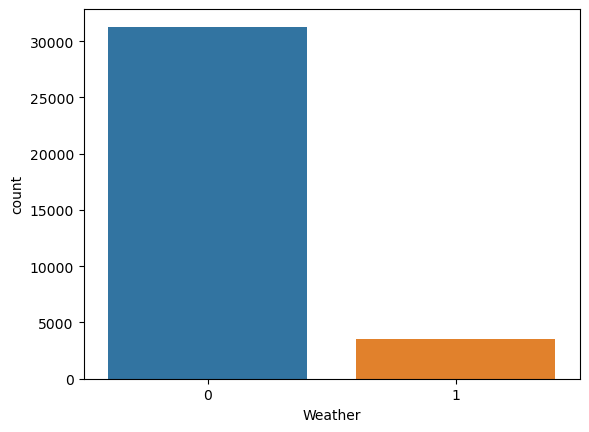

In [16]:
#plt df_sap
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x = 'Weather', data = df_sap)
plt.show()